In [21]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from matplotlib.lines import Line2D

import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average
from quantum_kernel.code.kernel_measures.eigenvalue_scaling import get_eigenvalue_scaling,compute_dataframe_kernel_eigenvalues

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 30}

rc('font', **font)

tqdm.pandas()
warnings.filterwarnings("ignore")


In [22]:
# Get kernel results for the different ml models and dataset.d
dfs = {}

folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/alpha_test/beta1.0/",'HZZ_Multi'),
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/alpha_test/beta0.1/",'HZZ_Multi'),
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/alpha_test/beta2.0/",'HZZ_Multi'),
]

folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/alpha_test2.0/beta1.0/",'HZZ_Multi'),
]

cols_to_drop=['qkern_matrix_train', 'args', 'K_train_time', 'rdms', 
'samples', 'mu','sigma', 'outpath','seed', 'projected']

for folder,prefix in folders:
    if prefix in dfs:
        temp = aggregate_shapes(folder,prefix,cols_to_drop=cols_to_drop)
        dfs[prefix] = pd.concat([dfs[prefix], temp])
    else:
        dfs[prefix] = aggregate_shapes(folder,prefix,cols_to_drop=cols_to_drop)

In [23]:
save_folder='/mnt/c/Users/lslat/Data/QK_project/results/figs/'

In [24]:
hzz_df=dfs['HZZ_Multi']

In [25]:
q_iqp_df=hzz_df[(hzz_df['h_layer']==1) & (hzz_df['non_data_int_scaling_factor']==0.0) & (hzz_df['scaling_factor']==hzz_df['int_scaling_factor'])]
c_iqp_df=hzz_df[(hzz_df['h_layer']==0) & (hzz_df['non_data_int_scaling_factor']==0.0) & (hzz_df['scaling_factor']==hzz_df['int_scaling_factor'])]

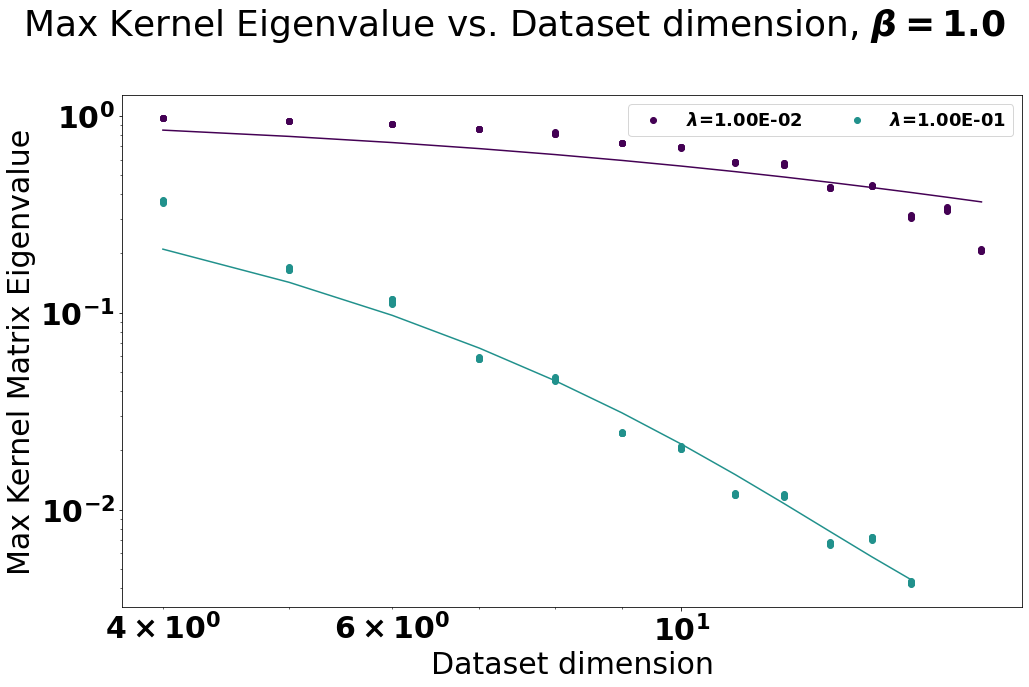

In [28]:
colormap=cm.viridis

beta=1.0
alpha=2.0

filter={'beta': beta,'alpha': alpha}
classical_df=filter_df(q_iqp_df,filter)

test_sfs=list(set(classical_df.scaling_factor))
test_sfs.sort()

fig, axs = plt.subplots(1,figsize=(15,10))
ax=axs
for i,sf in enumerate(test_sfs):
    color=colormap(i/len(test_sfs))
    label=r'$\lambda$={:.2E}'.format(sf)
    q_df=classical_df[(classical_df['scaling_factor']==sf)]
    x=q_df.dataset_dim
    y=q_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1)
    ax.scatter(x,y,color=color,label=label)

    

    x2=np.array(list(set(x.values)))

    #popt,pcov=scipy.optimize.curve_fit(lambda t,a,b: np.log(a*np.exp(b*t)),  x,  np.log(y))
    #y2=popt[0]*np.exp(popt[1]*x2)

    popt,pcov=scipy.optimize.curve_fit(lambda t,a,b,c: np.log(a*np.exp(-b*t)+c),  x,  np.log(y),bounds=([0,0,0], [1.0, 2.0, 0.3]))
    y2=popt[0]*np.exp(-popt[1]*x2)+popt[2]
    
    ax.plot(x2,y2,color=color)
    
ax.legend(bbox_to_anchor=(1,1),ncol=2,fontsize=18)
ax.set_xlabel('Dataset dimension')
ax.set_ylabel('Max Kernel Matrix Eigenvalue')
ax.set_xscale('log')
ax.set_yscale('log')
fig.suptitle(rf'Max Kernel Eigenvalue vs. Dataset dimension, $\beta = {beta}$')
fig.tight_layout()
#fig.savefig(f'{save_folder}quantum_IQP_eigenvalue_decay_curves_plots_beta_{beta}.png')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

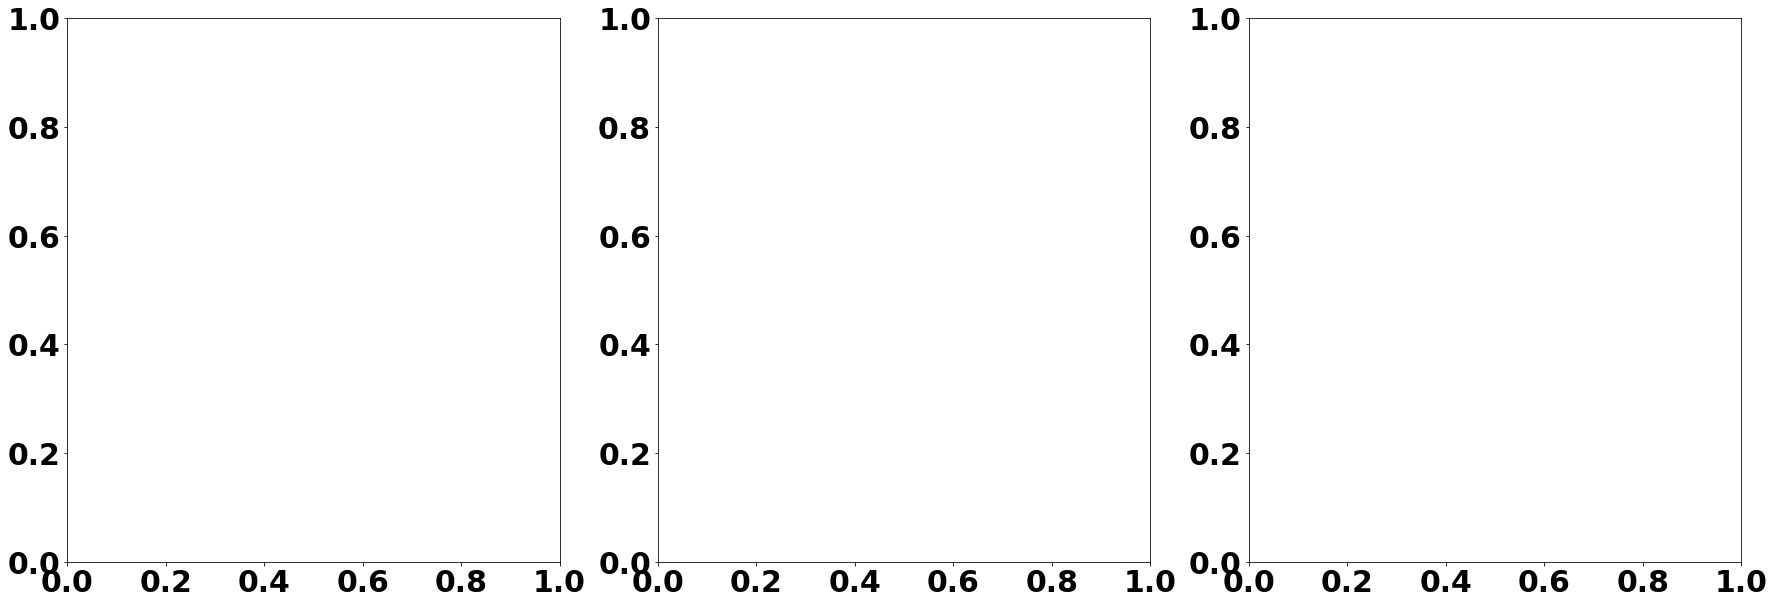

In [14]:
colormap=cm.viridis
gammas=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
alphas=[0.5,1.0,2.0]
beta=1.0
fig, axs = plt.subplots(1,len(alphas),figsize=(30,10))
for i,alpha in enumerate(alphas):
    filter={'beta': beta,'alpha': alpha}

    ax=axs[i]
    quantum_df=filter_df(q_iqp_df,filter)
    classical_df=filter_df(c_iqp_df,filter)

    lines=[]
    handles=[]
    for gamma in gammas:
        test_sfs=list(set(quantum_df.scaling_factor))
        test_sfs.sort()
        q_curve=get_eigenvalue_scaling(quantum_df,gamma,test_sfs)
        test_sfs=list(set(classical_df.scaling_factor))
        test_sfs.sort()
        c_curve=get_eigenvalue_scaling(classical_df,gamma,test_sfs)
        label=r'$\gamma_{max}$='+str(gamma)
        color=colormap(gamma)
        line=ax.errorbar(q_curve[:,0],q_curve[:,1],label=label,color=color)
        #_=ax.errorbar(c_curve[:,0],c_curve[:,1],color=color,ls='-.')
        lines.append(line[0])
        handles.append(label)

    ax.set_xlabel('Dataset dimension')
    ax.set_ylabel('IQP scaling factor')
    ax.set_xlim([4,19])
    #ax.set_ylim([10**(-1),2*10**0])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(r'$\beta$='+str(beta)+r', $\alpha$='+str(alpha))

fig.legend(lines,handles,bbox_to_anchor=(0.95,0.8),fontsize=18,ncol=2)
lines=[
    Line2D([0,0],[0.1,1],ls='-.',color=colormap(0.2)),
    Line2D([0,0],[0.1,1],ls='-',color=colormap(0.2))
]
extra_legend = plt.legend(lines, ["classical","quantum"], loc=1,fontsize=18)
fig.tight_layout()
#fig.savefig(f'{save_folder}IQP_fixed_gamma_decay_curves_plots.png')

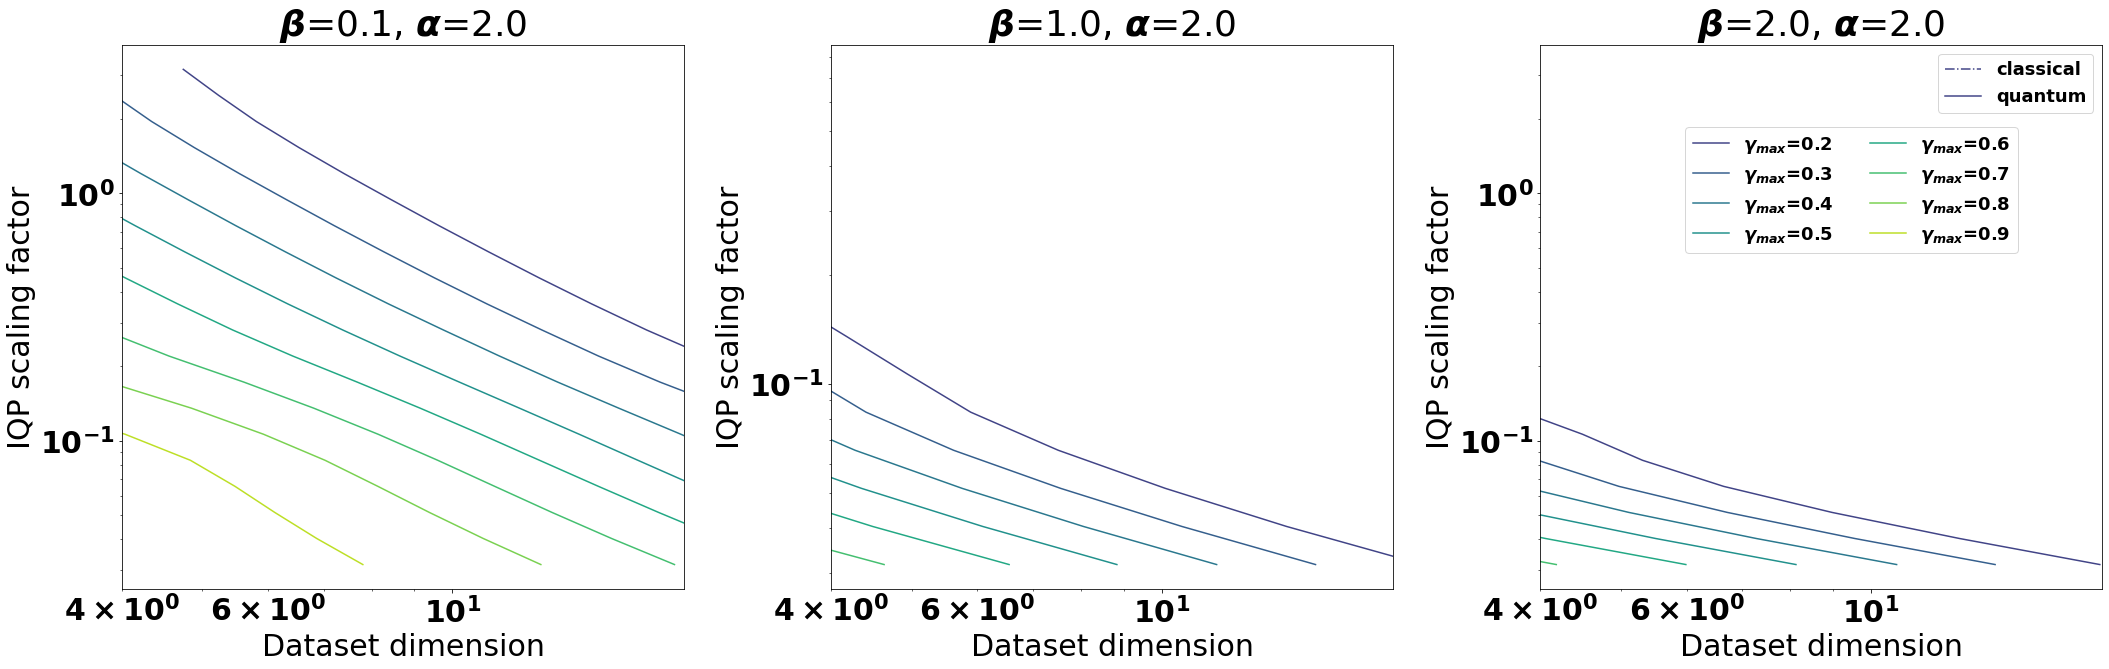

In [ ]:
colormap=cm.viridis
gammas=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
alpha=2.0
betas=[0.1, 1.0, 2.0]
fig, axs = plt.subplots(1,len(alphas),figsize=(30,10))
for i,beta in enumerate(betas):
    filter={'beta': beta,'alpha': alpha}

    ax=axs[i]
    quantum_df=filter_df(q_iqp_df,filter)
    classical_df=filter_df(c_iqp_df,filter)

    lines=[]
    handles=[]
    for gamma in gammas:
        test_sfs=list(set(quantum_df.scaling_factor))
        test_sfs.sort()
        q_curve=get_eigenvalue_scaling(quantum_df,gamma,test_sfs)
        test_sfs=list(set(classical_df.scaling_factor))
        test_sfs.sort()
        c_curve=get_eigenvalue_scaling(classical_df,gamma,test_sfs)
        label=r'$\gamma_{max}$='+str(gamma)
        color=colormap(gamma)
        line=ax.errorbar(q_curve[:,0],q_curve[:,1],label=label,color=color)
        #_=ax.errorbar(c_curve[:,0],c_curve[:,1],color=color,ls='-.')
        lines.append(line[0])
        handles.append(label)

    ax.set_xlabel('Dataset dimension')
    ax.set_ylabel('IQP scaling factor')
    ax.set_xlim([4,19])
    #ax.set_ylim([10**(-1),2*10**0])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(r'$\beta$='+str(beta)+r', $\alpha$='+str(alpha))

fig.legend(lines,handles,bbox_to_anchor=(0.95,0.8),fontsize=18,ncol=2)
lines=[
    Line2D([0,0],[0.1,1],ls='-.',color=colormap(0.2)),
    Line2D([0,0],[0.1,1],ls='-',color=colormap(0.2))
]
extra_legend = plt.legend(lines, ["classical","quantum"], loc=1,fontsize=18)
fig.tight_layout()
#fig.savefig(f'{save_folder}IQP_fixed_gamma_decay_curves_plots.png')

In [ ]:
#ugly maybe rewrite if time allows
def get_eigenvalue_scaling(df: pd.DataFrame,gamma,lambdas):
    """
    Take data frame with max eigenvalue of kernel column,lambda column and dataset dim column.
    Create interpolation between max eigenvalue vs. N for each value of lambda. Find N returning gamma using 
    the interpolation. return List[(N,lambda)] for gamma.
    """
    assert((gamma > 0) & (gamma <= 1.0)),'gamma must be between 0 and 1.'
    fitted_points=[]
    for lam in lambdas:
        lam_df=df[(df['scaling_factor']==lam)]
        #note xp and yp are different than lambda vs. N normally plotted because we want to interpolate to find the x intercept.
        xp=lam_df.dataset_dim
        xp=np.array(list(set(xp.values)))
        #sort for interpolation
        points=[]
        for x in xp:
            ys=lam_df[(lam_df['dataset_dim']==x)].apply(lambda x: max(x.kernel_eigenvalues),axis=1).values
            xs=np.array(len(ys)*[x])
            new_points=list(zip(xs,ys))
            points=points+new_points
        points=np.array(points) 
        #fit exponential decay to the points.
        x=points[:,0]
        y=points[:,1]

        #popt,pcov=scipy.optimize.curve_fit(lambda t,a,b: a+b*t,  x,  np.log(y))
        popt,pcov=scipy.optimize.curve_fit(lambda t,a,b,c: np.log(a*np.exp(-b*t)+c),  x,  np.log(y),bounds=(0, [1.0, 2.0, 0.2]))

        #solution np.log(y)=a+b*x -> y=exp(a)*exp(b*x)
        #now solve for x, np.log(gamma) = a+b*x -> x = (np.log(gamma)-a)/b
        #ypred=(np.log(gamma)-popt[0])/popt[1]
        ypred=-np.log((gamma-popt[2])/popt[0])/popt[1]
        #prediction interval t(1-a/2,number of data points - number of independent variables -1). 95% confidence interval.
        fitted_points.append((ypred,lam))

    return np.array(fitted_points)